# 加载基本库

In [1]:
import collections
import pandas as pd
import datetime
import ffmyh
import time
import math
# from sklearn import ensemble
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
# import lightgbm as lgb
from sklearn.metrics import log_loss
import xgboost
import matplotlib.pyplot as plt
pd.set_option('display.max_rows', 1000)
pd.set_option('display.max_columns', 100)
import sklearn
from sklearn.feature_extraction import DictVectorizer


# from fastFM.datasets import make_user_item_regression
# from fastFM import als
from sklearn.metrics import mean_squared_error
import scipy.sparse as sp
import numpy as np

sklearn.__version__

/Users/yuhua/anaconda2/lib/python2.7/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


'0.19.0'

# 加载数据项

In [2]:
train_df_org = pd.read_table('/Users/yuhua/先验CTR模型线上观察/Alimama比赛/round1_ijcai_18_train_20180301.txt',sep=' ')
test_df_org = pd.read_table('/Users/yuhua/先验CTR模型线上观察/Alimama比赛/round1_ijcai_18_test_a_20180301.txt',sep=' ')



In [10]:
train_df_org.columns

train_df = train_df_org.copy().set_index("context_id")
test_df = test_df_org.copy().set_index("context_id")

test_df["is_trade"] = -1
train_df = train_df.append(test_df)
# print len(train_df)
# print train_df[["is_trade"]]

# 预处理数据

In [12]:
# 时间处理: 分离天, 星期几, 上中下午/晚上, 小时数
# date最终不使用，直接用day(第 0 - 7 天)

from datetime import datetime

def extract_date(x):
    d = datetime.fromtimestamp(x)
    return d.strftime('%Y-%m-%d')
def extract_weekday(x):
    d = datetime.fromtimestamp(x)
    return d.weekday()
def extract_hour(x):
    d = datetime.fromtimestamp(x)
    return d.hour

train_df['date'] = train_df['context_timestamp'].apply(lambda x: extract_date(x))
train_df['weekday'] = train_df['context_timestamp'].apply(lambda x: extract_weekday(x))
train_df['hour'] = train_df['context_timestamp'].apply(lambda x: extract_hour(x))

m = {}
for idx, date in enumerate(sorted(train_df['date'].unique())):
    m[date]=idx
print m

for idx, d in enumerate(sorted(train_df['date'].unique())):
    train_df["day"] = train_df['date'].map(lambda x: m[x])

{'2018-09-24': 6, '2018-09-25': 7, '2018-09-20': 2, '2018-09-21': 3, '2018-09-22': 4, '2018-09-23': 5, '2018-09-19': 1, '2018-09-18': 0}


每天的交易率趋势和交易量趋势


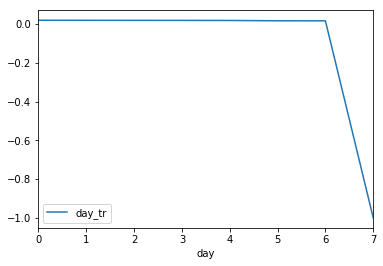

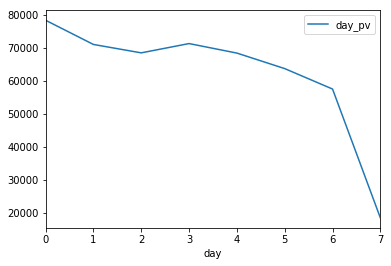

第0天的交易率趋势和交易量趋势


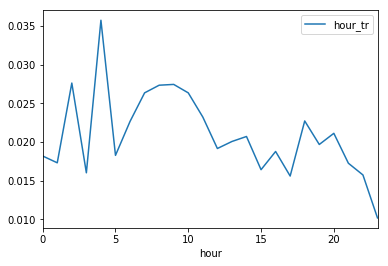

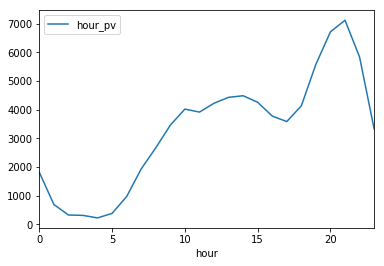

第1天的交易率趋势和交易量趋势


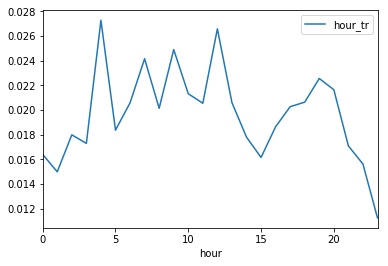

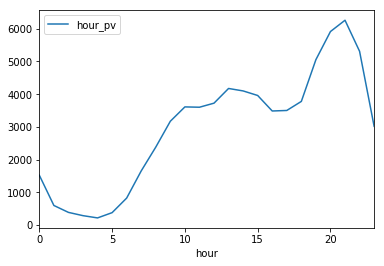

第2天的交易率趋势和交易量趋势


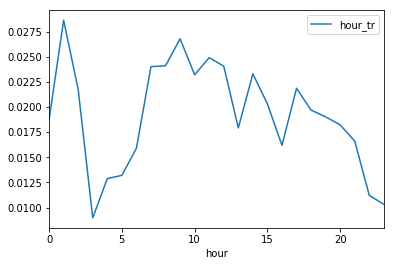

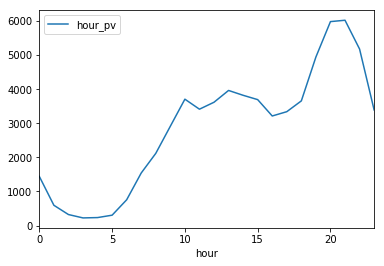

第3天的交易率趋势和交易量趋势


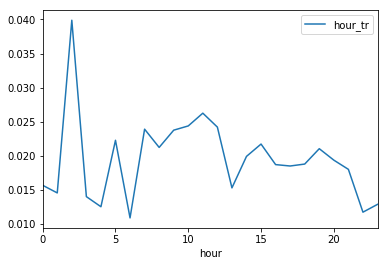

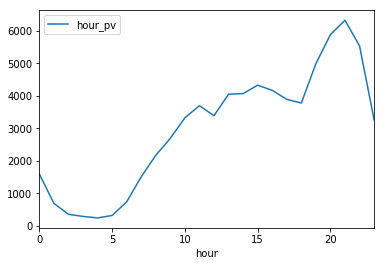

第4天的交易率趋势和交易量趋势


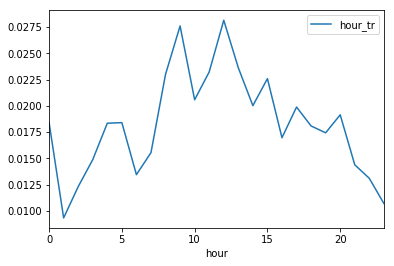

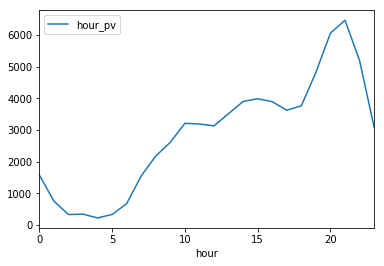

第5天的交易率趋势和交易量趋势


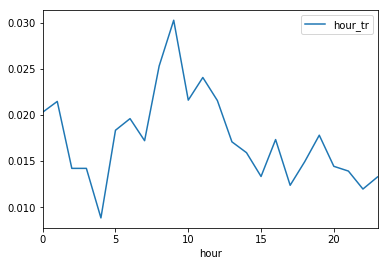

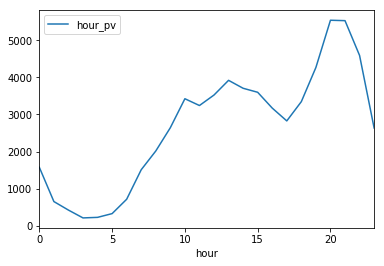

第6天的交易率趋势和交易量趋势


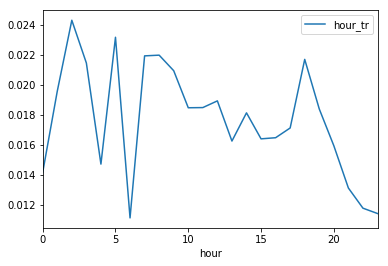

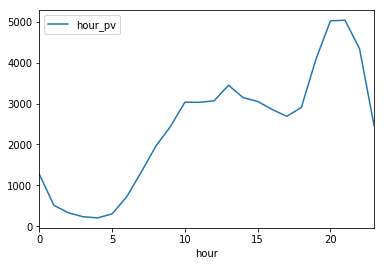

In [13]:
# import numpy as np  
import matplotlib.pyplot as plt
%matplotlib inline

def paintTradeCntAndRate(df, idCol):
    

    
    rateCol = idCol + '_tr'
    pvCol = idCol + '_pv'
    
    a = df.groupby([idCol]).agg({'is_trade':'sum'})
    b = df.groupby([idCol]).agg({'is_trade':'size'})
    c = a.join(b, lsuffix="_sum", rsuffix="_size")
    c[rateCol] = c['is_trade_sum'] / c['is_trade_size']
    c[pvCol] = c['is_trade_size']

    plt.figure()  
    c.plot(y=rateCol)
    c.plot(y=pvCol)
    plt.show()
    
print "每天的交易率趋势和交易量趋势"
paintTradeCntAndRate(train_df.copy(), "day")

for i in range(0, 7):
    print "第%s天的交易率趋势和交易量趋势" % i
    t = train_df.copy()
    paintTradeCntAndRate(t[t["day"] == i], "hour")
# df =pd.DataFrame(np.random.randn(1000, 4), columns=list('ABCD'))   
# df = df.cumsum()  
# plt.figure(); 
# df.plot(); 
# plt.legend(loc='best')  


# 拆解复杂类型

In [14]:
#简化list等复杂类型的结构
#item_category_list全展开
#item_property_list全展开取频率>0.05的数据
#predict_category_property会计算跟item prop和cate的余弦相似度
#具体是把两个list的数据拼成cate:-1和cate:prop两种方式拼成一个字符串再跟predict_category_property的数据计算相似度
def get_icl_map(df):
    print "get_icl_map ... "
    dfX = df.copy()
    dfX = dfX['item_category_list'].str.split(';', expand=True)

#     s = sorted(list(dfX[0].unique()) + list(dfX[1].unique()) + list(dfX[2].unique()))
    m = {}
    for i in dfX[0].unique():
        if i == None:
            continue
        m[i] = "1"
    
    for i in dfX[1].unique():
        if i == None:
            continue
        m[i] = "2"
    
    for i in dfX[2].unique():
        if i == None:
            continue
        m[i] = "3"
    return m

def get_ipl_map(df):
    print "get_ipl_map ... "
    df1 = df.copy()
    dfX = df1.copy()['item_property_list'].str.split(';')
    dfX = pd.DataFrame(dfX)
    
    m = collections.defaultdict(float)
    idx = 0
    for _, row in dfX.iterrows():
        for i in row[0]:
            m[i] += 1
    
    ll = len(dfX)
    for k,v in m.items():
        m[k] = v / ll
    return m

def process_complex_types(dfX, icl_map, ipl_map):
    def filter_unless_cate(arr):
        ret = []
        for i in arr:
            if i in icl_map:
                ret.append(i)
        if len(ret) == 0:
            return None
        else:
            return ret
    
    def filter_unless_prop(arr):
        ret = []
        for i in arr:
            freq = ipl_map.get(i, 0.)
            if freq > 0.05:
                ret.append(i)
        if len(ret) == 0:
            return None
        else:
            return ret
    
    #{cate}:-1命中则为1分
    #{cate}:{prop}命中则为2分
    #后期优化权重
    def inner_product_recall_items(line):
        line = line.split("|")
        item_category_list = line[0].split(";")
        item_property_list = line[1].split(";")
        
        whole_combines = {}
        for cate in item_category_list:
            tmp = cate+":"+"-1"
            whole_combines[tmp] = 1
            for prop in item_property_list:
                tmp = cate+":"+prop
                whole_combines[tmp] = 2
        
        
                
        predict_category_property = line[2].split(";")
        product = 0.
        item_vec_len = math.sqrt(len(whole_combines))
        user_vec_len = math.sqrt(len(predict_category_property))
        for item in predict_category_property:
            #x1 == 1
            #y1 == 1
            #x1*y1 == 1
            #x2 == 0
            #y2 == 1
            #x2*y2 == 0
            #所以product由x决定 += 1/0
            product += whole_combines.get(item, 0)
        
        return product/(item_vec_len*user_vec_len)
            
        
            
        
        
        
    print "processing predict_category_property ..."
#     dfX['predict_category_property'] = dfX['predict_category_property'].str.split(';').map(lambda x: [i.split(":")[0] for i in x]).map(filter_unless_cate)
    
    dfX['predict_richness'] =  dfX['predict_category_property'].map(lambda x: 0 if len(x.strip()) == 0 else len(x.split(";")))
    dfX['predict_category_property'] = dfX['item_category_list']+"|"+dfX['item_property_list']+"|"+dfX['predict_category_property']
    dfX['predict_category_property'] = dfX['predict_category_property'].map(inner_product_recall_items)
    
    print "processing item_property_list ..."
    dfX['item_property_richness'] = dfX['item_property_list'].map(lambda x: 0 if len(x.strip()) == 0 else len(x.split(";")))
    dfX['item_property_list'] = dfX['item_property_list'].str.split(';').map(filter_unless_prop)
    
    print "processing item_category_list ..."
    dfX['item_category_list'] = dfX['item_category_list'].str.split(';')
    
#     print "generating item_category_list01 - item_category_list03 ..."
#     dfX['item_category_list01'] = dfX['item_category_list'].map(lambda x:x[0] if x != None and len(x) > 0 else None)
#     dfX['item_category_list02'] = dfX['item_category_list'].map(lambda x:x[1] if x != None and len(x) > 1 else None)
#     dfX['item_category_list03'] = dfX['item_category_list'].map(lambda x:x[2] if x != None and len(x) > 2 else None)
    
    return dfX



# aaa = process_complex_types(train_df.copy(), get_icl_map(train_df), get_ipl_map(train_df))

train_df = process_complex_types(train_df, get_icl_map(train_df), get_ipl_map(train_df))


get_icl_map ... 
get_ipl_map ... 
processing predict_category_property ...
processing item_property_list ...
processing item_category_list ...


# 转化属性增加trade_rate + trade_pv（按前一天）

In [15]:
# 统计信息附加

def calcTVTransform(df, key, key_y, filter_src, filter_dst, smoothing = 10, mean0=None):
    if mean0 is None:
        #计算目标的平均值做平缓用
        mean0 = df.ix[filter_src, key_y].mean()
        print "mean0:", mean0
    
    #取出key的所有值
    df['_key1'] = df[key].astype('category').values.codes
    
    
    #取出用于计算的源（后面聚合掉就没有顺序可言了）
    df_key1_y = df.ix[filter_src, ['_key1', key_y]]
    
    #根据key的取值去聚合key_y的总数和总和，用户计算rate和count
    grp1 = df_key1_y.groupby(['_key1'])
    sum1 = grp1[key_y].aggregate(np.sum)
    cnt1 = grp1[key_y].aggregate(np.size)
    
    vn_sum = 'sum_' + key
    vn_cnt = 'cnt_' + key
    
    #取出dst（带序列）的所有key
    v_codes = df.ix[filter_dst, '_key1']
    
    #得到_sum,_cnt，按dst的序列
    _sum = sum1[v_codes].values
    _cnt = cnt1[v_codes].values
    _cnt[np.isnan(_sum)] = 0    
    _sum[np.isnan(_sum)] = 0
    
    r = {}
    r['exp'] = (_sum + smoothing * mean0)/(_cnt + smoothing)
    r['cnt'] = _cnt
    return r


In [16]:
#计算前一天的交易率set到下一天，第0天用回自己
# tmp = train_df.copy()
tmp = train_df

add_count = False
# window = 2

exp = "exp_d_"
cnt = "cnt_d_"


exp_numerical = {}
cnt_numerical = {}

#此处应该处理按天为梯度的数据
for k in ['item_price_level',
'item_sales_level',
'item_collected_level',
'item_pv_level',
'user_gender_id',
'user_age_level',
'user_occupation_id',
'user_star_level',
'context_page_id',
'shop_review_num_level',
'shop_star_level']:
    exp_k = exp+k
    cnt_k = cnt+k
    for day in xrange(0,8):
#         start_d = max(day - window, 0)
#         end_d = max(day - 1,0)
        cal_day = max(day - 1, 0)
        set_day = day

        print "cal %s trade_rate cnt %s set to %s" % (k,cal_day, set_day)
        
        #start_d - day(不含day)用于计算，结果赋值到day上
        days1 = (tmp.day.values == cal_day)
        days2 = (tmp.day.values == set_day)
        ret = calcTVTransform(tmp, k, 'is_trade', days1, days2)
            
        tmp.loc[tmp.day.values == day, exp_k] = ret["exp"]
        
        exp_numerical[exp_k]=1
        if add_count:
            cnt_numerical[cnt_k]=1
            tmp.loc[tmp.day.values == day, cnt_k] = ret["cnt"]


cal item_price_level trade_rate cnt 0 set to 0
mean0: 0.0200209536464


/Users/yuhua/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:6: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
  


cal item_price_level trade_rate cnt 0 set to 1
mean0: 0.0200209536464
cal item_price_level trade_rate cnt 1 set to 2
mean0: 0.0196810985324
cal item_price_level trade_rate cnt 2 set to 3
mean0: 0.0193604047553
cal item_price_level trade_rate cnt 3 set to 4
mean0: 0.0193120689897
cal item_price_level trade_rate cnt 4 set to 5
mean0: 0.0188676483504
cal item_price_level trade_rate cnt 5 set to 6
mean0: 0.0172760713051
cal item_price_level trade_rate cnt 6 set to 7
mean0: 0.0169101896519
cal item_sales_level trade_rate cnt 0 set to 0
mean0: 0.0200209536464
cal item_sales_level trade_rate cnt 0 set to 1
mean0: 0.0200209536464
cal item_sales_level trade_rate cnt 1 set to 2
mean0: 0.0196810985324
cal item_sales_level trade_rate cnt 2 set to 3
mean0: 0.0193604047553
cal item_sales_level trade_rate cnt 3 set to 4
mean0: 0.0193120689897
cal item_sales_level trade_rate cnt 4 set to 5
mean0: 0.0188676483504
cal item_sales_level trade_rate cnt 5 set to 6
mean0: 0.0172760713051
cal item_sales_level

# 转化属性增加trade_pv（按上一小时）

In [17]:
# tmp = train_df.copy()
# # tmp = train_df

# add_count = False

# exp = "exp_h_"
# cnt = "cnt_h_"


# #此处应该处理按天为梯度的数据
# for k in ['item_price_level',
# 'item_sales_level',
# 'item_collected_level',
# 'item_pv_level',
# 'user_gender_id',
# 'user_age_level',
# 'user_occupation_id',
# 'user_star_level',
# 'context_page_id',
# 'shop_review_num_level',
# 'shop_star_level',
# 'item_brand_id',
# 'item_city_id',
# 'item_id',
# 'shop_id'
# ]:
#     exp_k = exp+k
#     cnt_k = cnt+k
#     for day in xrange(0,7):
#         for hour in xrange(1,24):
#             cal_hour = max(hour-1,0)
#             set_hour = hour
#             print "cal %s trade_rate cnt day %s hour %s set to %s" % (k, day, cal_hour, set_hour)

#             hcal = np.logical_and(tmp.day.values == day, tmp.hour.values == cal_hour)
#             hset = np.logical_and(tmp.day.values == day, tmp.hour.values == set_hour)
#             ret = calcTVTransform(tmp, k, 'is_trade', hcal, hset)

#             tmp.loc[tmp.day.values == day, exp_k] = ret["exp"]

#             exp_numerical[exp_k]=1
#             if add_count:
#                 cnt_numerical[cnt_k]=1
#                 tmp.loc[tmp.day.values == day, cnt_k] = ret["cnt"]



In [18]:
exp_numerical = exp_numerical.keys()
cnt_numerical = cnt_numerical.keys()

print exp_numerical
print cnt_numerical

['exp_d_user_age_level', 'exp_d_item_pv_level', 'exp_d_shop_review_num_level', 'exp_d_item_sales_level', 'exp_d_user_occupation_id', 'exp_d_user_star_level', 'exp_d_item_price_level', 'exp_d_shop_star_level', 'exp_d_item_collected_level', 'exp_d_user_gender_id', 'exp_d_context_page_id']
[]


# 标记训练用的列

In [19]:
#标记训练数据

target="is_trade"
                          
                          
                        
categorical=[  
#                 'shop_id',
#                 'item_brand_id',
#                 'item_city_id',
                'item_price_level',
                'item_sales_level',
                'item_collected_level',
                'item_pv_level',
                'user_gender_id',
                'user_age_level',
                'user_occupation_id',
                'user_star_level',
                'context_page_id',
                'shop_review_num_level',
                'shop_star_level',
                "weekday",
                "hour"]

numerical=[     'shop_review_positive_rate',
                'shop_score_service',
                'shop_score_delivery',
                'shop_score_description',
                'predict_category_property',
                'predict_richness',
                'item_property_richness'
                   

#                 'item_id',
#                 'user_id'
          ]+exp_numerical
listype = [
    'item_property_list', 
    'item_category_list'
]

class filter_on_cols:
    def __init__(self, target, categorical, numerical, listype):
        self.target = target
        self.categorical = categorical
        self.numerical = numerical
        self.listype = listype
        

    
#     def get_raw_simple_cols(self):
#         return [self.target]+self.categorical+self.numerical
    def get_raw_target_col(self):
        return self.target
    def get_raw_categorical_cols(self):
        return self.categorical
    
    def get_raw_numerical_cols(self):
        return self.numerical
    def get_raw_listype_cols(self):
        return self.listype
    
    def get_onehoted_cols(self, t, df):
        if t == "listype":
            org_cols = self.listype
        
        if t == "categorical":
            org_cols = self.categorical
            
        ret = []
        for org_col in org_cols:
            for cur_col in list(df.columns):
                if cur_col.find("*ONEHOT*_") != -1 and cur_col.find(org_col) != -1:
                    ret.append(cur_col)
        
        return ret
                    
                    
            
            

filter_on_cols = filter_on_cols(target, categorical, numerical, listype)

In [20]:
train_df[filter_on_cols.get_raw_numerical_cols()].describe()

,shop_review_positive_rate,shop_score_service,shop_score_delivery,shop_score_description,predict_category_property,predict_richness,item_property_richness,exp_d_user_age_level,exp_d_item_pv_level,exp_d_shop_review_num_level,exp_d_item_sales_level,exp_d_user_occupation_id,exp_d_user_star_level,exp_d_item_price_level,exp_d_shop_star_level,exp_d_item_collected_level,exp_d_user_gender_id,exp_d_context_page_id
count,496509.000000,496509.000000,496509.000000,496509.000000,496509.000000,496509.000000,496509.000000,496509.000000,496509.000000,496509.000000,496509.000000,496509.000000,496509.000000,496509.000000,496509.000000,496509.000000,496509.000000,496509.000000
mean,0.994833,0.971131,0.970495,0.974870,0.104144,4.810191,34.475055,0.019209,0.019185,0.019207,0.019196,0.019197,0.019192,0.019122,0.019197,0.019206,0.019201,0.019208
std,0.011875,0.023607,0.023567,0.024823,0.074287,1.795871,10.150529,0.003042,0.002614,0.003695,0.005910,0.001739,0.002805,0.008289,0.003712,0.002980,0.001895,0.002703
min,-1.000000,-1.000000,-1.000000,-1.000000,0.000000,1.000000,6.000000,0.001875,0.001393,0.001763,0.001014,0.001875,0.001875,0.001889,0.001033,0.001057,0.010130,0.004412
25%,0.992780,0.966360,0.965677,0.969282,0.052705,3.000000,29.000000,0.017565,0.017940,0.017704,0.015128,0.018679,0.018384,0.014195,0.016709,0.017904,0.018869,0.018735
50%,1.000000,0.972347,0.971579,0.978493,0.099015,5.000000,33.000000,0.019105,0.019256,0.018838,0.019286,0.019032,0.019564,0.016366,0.018953,0.019162,0.019397,0.019370
75%,1.000000,0.977822,0.976966,0.983626,0.148888,6.000000,39.000000,0.020799,0.020019,0.021639,0.022023,0.019853,0.020863,0.023361,0.022549,0.020534,0.019800,0.020518
max,1.000000,1.000000,1.000000,1.000000,0.632456,14.000000,100.000000,0.027407,0.108061,0.066678,0.037022,0.022668,0.046764,0.079541,0.085729,0.035166,0.023103,0.025987


# 平滑处理连续型数据最后对复杂类型做onehot编码

In [21]:
tmp = train_df.copy()

In [ ]:
#数据的预处理
#double系列(例如好评率)的数据存在一个问题，没有考虑到评论量，所以乘了一个评论level，类似 好评率*评论数(分桶了) = 好评量(分桶了)
#fillempty把-1设置成-0.01，配合mov2pos使用
#mov2pos把有<0的数据都集体-min，如果一个数据是0-1，有-1出现的时候，上面设置成了-0.01，所以这列数据真实是-0.01 - 1,然后我会集体-(-0.01)
#norm用了最大值最小值norm
%run FeatureProcess.py

train_df = tmp.copy()
featProc = FeatureProcess(target=target, categorical=categorical, numerical=numerical, listype = listype)

train_df["shop_review_num_level"] = train_df["shop_review_num_level"]
train_df["shop_review_positive_rate"] = train_df["shop_review_positive_rate"]*train_df["shop_review_num_level"]
train_df["shop_score_service"] = train_df["shop_score_service"]*train_df["shop_review_num_level"]
train_df["shop_score_delivery"] = train_df["shop_score_delivery"]*train_df["shop_review_num_level"]
train_df["shop_score_description"] = train_df["shop_score_description"]*train_df["shop_review_num_level"]

train_df = featProc.fillempty(train_df, -0.01)
train_df = featProc.mov2pos(train_df)
train_df = featProc.norm(train_df)
train_df[filter_on_cols.get_raw_numerical_cols()].describe()


train_df[filter_on_cols.get_raw_numerical_cols()].describe()

In [ ]:
#onehot没啥好说的，就是onehot，toOneHotList实现有点不同分开了而已
train_df = featProc.toOneHot(train_df)
train_df = featProc.toOneHotList(train_df)

# train_df = featProc.cacheRun(featProc.toOneHot, train_df)
for c in train_df.columns:
    print c



# 定义模型函数

In [ ]:
%run ffmyh.py

    
# def train_and_test_combine(train_df, test_df, res_df):
    
#     X_train = train_df.copy()
#     del X_train['is_trade']
#     y_train = train_df['is_trade']
    
#     X_test = test_df.copy()
#     del X_test['is_trade']
#     y_test = test_df['is_trade']
    
    
    
#     model = xgboost.XGBClassifier(nthread=7,max_depth=5)
#     model.fit(X_train, y_train)
    
#     y_prev_predict_train = pd.DataFrame(model.predict_proba(X_train))
#     y_prev_predict_train["idx"] = X_train.index
#     y_prev_predict_train = y_prev_predict_train.set_index("idx")
#     X_train["y_prev_predict"] = y_prev_predict_train[1]
    
#     y_prev_predict_test = pd.DataFrame(model.predict_proba(X_test))
#     y_prev_predict_test["idx"] = X_test.index
#     y_prev_predict_test = y_prev_predict_test.set_index("idx")
#     X_test["y_prev_predict"] = y_prev_predict_test[1]
    
    
# #     X_train = X_train.fillna(0)
# #     X_test = X_test.fillna(0)
    
    
#     model = LogisticRegression(max_iter=1000)
#     model.fit(X_train, y_train)
    
    
#     train_lls = log_loss(y_train,model.predict_proba(X_train))
#     test_lls = log_loss(y_test,model.predict_proba(X_test))
#     del train_df
#     del test_df
    
#     del X_train
#     del y_train
#     del X_test
#     del y_test
    
#     return train_lls, test_lls
    

def train_and_test_xgboost(train_df, test_df, res_df):    
    X_train = train_df.copy()
    del X_train['is_trade']
    y_train = train_df['is_trade']
    
    X_test = test_df.copy()
    del X_test['is_trade']
    y_test = test_df['is_trade']
    
    
#     model = xgboost.XGBClassifier(reg_lambda=1.5,learning_rate=0.1,reg_alpha=0,nthread=7,n_estimators=100,max_depth=10)
    model = xgboost.XGBClassifier(nthread=7)
    model.fit(X_train, y_train)
    
    train_lls = log_loss(y_train,model.predict_proba(X_train))
    test_lls = log_loss(y_test,model.predict_proba(X_test))
    
    if type(res_df) != type(None):
        del res_df["is_trade"]
        res_df = res_df.reset_index(drop=True)
        instance_id_list = res_df[["instance_id"]]
        del res_df["instance_id"]
        predicted_score = pd.DataFrame(model.predict_proba(res_df))
        
        instance_id_list["predicted_score"] = predicted_score[1]
        instance_id_list.to_csv("xgboost_res.csv",index=False,sep=' ')
        
    
    del train_df
    del test_df
    
    del X_train
    del y_train
    del X_test
    del y_test
    
    return train_lls, test_lls

def train_and_test_lr(train_df, test_df, res_df):    
    X_train = train_df.copy()
    del X_train['is_trade']
    y_train = train_df['is_trade']
    
    X_test = test_df.copy()
    del X_test['is_trade']
    y_test = test_df['is_trade']
    
    model = LogisticRegression(n_jobs=7,tol=1e-6, max_iter=2000)
    model.fit(X_train, y_train)


    train_lls = log_loss(y_train,model.predict_proba(X_train))
    test_lls = log_loss(y_test,model.predict_proba(X_test))
    
    if type(res_df) != type(None):
        del res_df["is_trade"]
        res_df = res_df.reset_index(drop=True)
        instance_id_list = res_df[["instance_id"]]
        del res_df["instance_id"]
        predicted_score = pd.DataFrame(model.predict_proba(res_df))
        
        instance_id_list["predicted_score"] = predicted_score[1]
        instance_id_list.to_csv("lr_res.csv",index=False,sep=' ')
    
    del train_df
    del test_df
    
    del X_train
    del y_train
    del X_test
    del y_test
    
    return train_lls, test_lls

def train_and_test_randomforest(train_df, test_df, res_df):    
    X_train = train_df.copy()
    del X_train['is_trade']
    y_train = train_df['is_trade']
    
    X_test = test_df.copy()
    del X_test['is_trade']
    y_test = test_df['is_trade']
    
#     rf = RandomForestClassifier(n_estimators=32, max_depth=40, min_samples_split=100, min_samples_leaf=10,  criterion='entropy',
#                         max_features=8, verbose = 1,  bootstrap=False, n_jobs=10)
#     RandomForestClassifier(criterion='entropy',n_estimators=100,n_jobs=15)

    model = RandomForestClassifier(n_estimators=100, max_depth=10, min_samples_split=100, min_samples_leaf=10,  criterion='entropy', max_features=8, verbose = 1,  bootstrap=False)
    model.fit(X_train, y_train)
    
    train_lls = log_loss(y_train,model.predict_proba(X_train))
    test_lls = log_loss(y_test,model.predict_proba(X_test))
    
    if type(res_df) != type(None):
        del res_df["is_trade"]
        res_df = res_df.reset_index(drop=True)
        instance_id_list = res_df[["instance_id"]]
        del res_df["instance_id"]
        predicted_score = pd.DataFrame(model.predict_proba(res_df))
        
        instance_id_list["predicted_score"] = predicted_score[1]
        instance_id_list.to_csv("randomforest_res.csv",index=False,sep=' ')
        
    del train_df
    del test_df
    
    del X_train
    del y_train
    del X_test
    del y_test
    
    return train_lls, test_lls

def train_and_test_gbdt(train_df, test_df, res_df):
    X_train = train_df.copy()
    del X_train['is_trade']
    y_train = train_df['is_trade']
    
    X_test = test_df.copy()
    del X_test['is_trade']
    y_test = test_df['is_trade']
    
    model = GradientBoostingClassifier(n_estimators=100, max_depth=10, min_samples_split=100, min_samples_leaf=10, max_features=4)
    model.fit(X_train, y_train)
    
    train_lls = log_loss(y_train,model.predict_proba(X_train))
    test_lls = log_loss(y_test,model.predict_proba(X_test))
    
    if type(res_df) != type(None):
        del res_df["is_trade"]
        res_df = res_df.reset_index(drop=True)
        instance_id_list = res_df[["instance_id"]]
        del res_df["instance_id"]
        predicted_score = pd.DataFrame(model.predict_proba(res_df))
        
        instance_id_list["predicted_score"] = predicted_score[1]
        instance_id_list.to_csv("gbdt_res.csv",index=False,sep=' ')
        
    del train_df
    del test_df
    
    del X_train
    del y_train
    del X_test
    del y_test
    
    return train_lls, test_lls

# def train_and_test_FM(train_df, test_df, valid_):
    
#     f = [  
#                                             'shop_id',
#                                             'item_brand_id',
#                                             'item_city_id',
#                                             'item_price_level',
#                                             'item_sales_level',
#                                             'item_collected_level',
#                                             'item_pv_level',
#                                             'user_gender_id',
#                                             'user_age_level',
#                                             'user_occupation_id',
#                                             'user_star_level',
#                                             'context_page_id',
#                                             'shop_review_num_level',
#                                             'shop_star_level']
    
# #     train_df = train_df.fillna(0)
# #     test_df = test_df.fillna(0)
#     X_train = train_df[f]
#     y_train = train_df["is_trade"]
    
#     X_test = test_df[f]
#     y_test = test_df["is_trade"]
    
#     X_train_dicts = X_train.to_dict('records')
#     X_test_dicts = X_test.to_dict('records')
    
    
#     vec = DictVectorizer()
#     vectorizer = vec.fit_transform(X_train_dicts)
#     fm_X_train = sp.csc_matrix(vectorizer)
    
#     vec = DictVectorizer()
#     vectorizer = vec.fit_transform(X_test_dicts)
#     fm_X_test = sp.csc_matrix(vectorizer)

#     model = als.FMRegression(n_iter=10000, init_stdev=0.1, l2_reg_w=0, l2_reg_V=0, rank=5)
#     model.fit(fm_X_train, y_train)
    
    
    
    
#     train_lls = log_loss(y_train,model.predict(fm_X_train))
#     test_lls = log_loss(y_test,model.predict(fm_X_test))
#     del train_df
#     del test_df
    
#     del X_train
#     del y_train
#     del X_test
#     del y_test
    
#     return train_lls, test_lls

def train_and_test_FFM(train_df, test_df, res_df):
    global filter_on_cols
    
    model = FFM(target=filter_on_cols.target, categorical=filter_on_cols.categorical, numerical=filter_on_cols.numerical, listype=filter_on_cols.listype,
                                        reg_param = 0.0004,
                                        k = 4,
                                        iter_max = 500,
                                        learing_rate = 0.1,
                                        threads = 5,
                                        auto_stop = False,
                                        quiet = False,
                                        no_norm = False)


    
#     model.fit(train_df, test_df)
    model.fit(train_df, test_df)
    
    train_lls = log_loss(train_df["is_trade"],model.predict_proba(train_df))
    test_lls = log_loss(test_df["is_trade"],model.predict_proba(test_df))
    
    return train_lls, test_lls


# 开搞！

In [ ]:
#这块一般不怎么需要改了，拿最后一天做验证
#注意下面验证版和测试版，测试版是我们自己玩的，验证版是扔线上的，通过注释不同的跑就行了

# %run BaseFrame.py
% run ../util/time_series_split.py

tmp_train_df = train_df.copy().fillna(0)


categorical_one_hot_cols = filter_on_cols.get_onehoted_cols("categorical", tmp_train_df)
listype_one_hot_cols = filter_on_cols.get_onehoted_cols("listype", tmp_train_df)

# index_col = "instance_id"
# tmp_train_df = tmp_train_df.drop_duplicates([index_col])
# tmp_train_df.set_index(index_col)


categorical_cols = filter_on_cols.get_raw_categorical_cols()
listype_cols = filter_on_cols.get_raw_listype_cols()
numerical_cols = filter_on_cols.get_raw_numerical_cols()
target_col = filter_on_cols.get_raw_target_col()


print "org dataset =", len(tmp_train_df)
print tmp_train_df["day"].value_counts()


# tmp_train_df = featProc.balance_pos_neg_sample(tmp_train_df, (1,10))
# print "sampling dataset =", len(tmp_train_df)
# print tmp_train_df["day"].value_counts()

# 抽样
# tmp_train_df = tmp_train_df.sample(n=10000, random_state=666)
# print "sampling dataset =", len(tmp_train_df)

print tmp_train_df["day"].value_counts()

#测试版
valid_df = tmp_train_df.loc[tmp_train_df["day"]==6]
tmp_train_df = tmp_train_df.loc[tmp_train_df["day"]<6]
res_df=valid_df.copy()

# #线上验证版
# valid_df = tmp_train_df.loc[tmp_train_df["day"]==6]
# res_df = tmp_train_df.loc[tmp_train_df["day"]==7]
# tmp_train_df = tmp_train_df.loc[tmp_train_df["day"]<=6]

print "res dataset =", len(res_df)
print "valid dateset =", len(valid_df)
print "train dateset =", len(tmp_train_df)

# tmp_train_df = tmp_train_df[on_cols]
# valid_df = valid_df[on_cols]


on_cols = [target_col]+numerical_cols+categorical_one_hot_cols+listype_one_hot_cols

train_lls, test_lls = train_and_test_lr(tmp_train_df[on_cols], valid_df[on_cols], res_df[on_cols+[index_col]])
print "LR %s dimension TrainLogLoss = %s | TestLogLoss = %s" % (len(tmp_train_df[on_cols].columns), train_lls, test_lls)

on_cols = [target_col]+categorical_cols+numerical_cols+listype_one_hot_cols
train_lls, test_lls = train_and_test_xgboost(tmp_train_df[on_cols], valid_df[on_cols], res_df[on_cols+[index_col]])
print "XGBoost %s dimension TrainLogLoss = %s | TestLogLoss = %s" % (len(tmp_train_df[on_cols].columns), train_lls, test_lls)

on_cols = [target_col]+categorical_cols+numerical_cols+listype_one_hot_cols
train_lls, test_lls = train_and_test_randomforest(tmp_train_df[on_cols], valid_df[on_cols], res_df[on_cols+[index_col]])
print "RandomForest %s dimension TrainLogLoss = %s | TestLogLoss = %s" % (len(tmp_train_df[on_cols].columns), train_lls, test_lls)

on_cols = [target_col]+categorical_cols+numerical_cols+listype_one_hot_cols
train_lls, test_lls = train_and_test_gbdt(tmp_train_df[on_cols], valid_df[on_cols], res_df[on_cols+[index_col]])
print "GBDT %s dimension TrainLogLoss = %s | TestLogLoss = %s" % (len(tmp_train_df[on_cols].columns), train_lls, test_lls)


# train_lls, test_lls = train_and_test_combine(tmp_train_df[on_cols], valid_df[on_cols])
# print "Combine TrainLogLoss = %s | TestLogLoss = %s" % (train_lls, test_lls)


# # train_lls, test_lls = train_and_test_FFM(tmp_train_df, valid_df)
# # print "FFM TrainLogLoss = %s | TestLogLoss = %s" % (train_lls, test_lls)



